## About

This is an implementation a famous [paper](https://arxiv.org/abs/1703.02442) that used machine learning to predict cancer cells from tumor slides. It is a stripped down version of the paper's work, but runs end to end using multiple slide zoom levels, high magnification of images, and visualizations of the results. I also implemented similar data augmenations to those used in the paper, with interesting results discussed later. 

### Training data

The original slides and annotations are in an unusual format. The professor converted several of them for the class to use on this project. Slides are read at the 5 and 3 magnification levels only to limit the heavy demands on memory and RAM in google Colab. 

The professor also provided some starter code to download and display a slide, which I built upon.

In [1]:
# Install the OpenSlide C library and Python bindings
%%capture
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image, ImageStat, ImageEnhance, ImageOps
from skimage.color import rgb2gray
from sklearn.metrics import roc_auc_score, classification_report

In [3]:
print(tf.__version__)

2.9.2


In [4]:
# Download a slide and tumor mask
def download_slide(slide_name, mask_name):

  slide_url = 'https://storage.googleapis.com/adl_project_slides/slides/%s' % slide_name
  mask_url = 'https://storage.googleapis.com/adl_project_slides/slides/%s' % mask_name

  # Download the whole slide image
  if not os.path.exists(slide_url):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(mask_url):
    !curl -O $mask_url

In [5]:
slide_name = 'tumor_091.tif'
mask_name = 'tumor_091_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  91.2M      0  0:00:05  0:00:05 --:--:--  101M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  52.3M      0 --:--:-- --:--:-- --:--:-- 52.3M


In [6]:
slide = open_slide(slide_name)
print ("Read WSI from %s with width: %d, height: %d" % (slide_name, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(mask_name)
print ("Read tumor mask from %s" % (mask_name))

print("Slide includes %d levels" % len(slide.level_dimensions))
print("Tumor mask includes %d levels" % len(tumor_mask.level_dimensions))
for i in range(min(len(tumor_mask.level_dimensions), len(slide.level_dimensions))):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
print("slide width: %d, slide height: %d" % (width, height))
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes 8 levels
Tumor mask includes 8 levels
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128
slide width: 480, slide height: 420


In [7]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

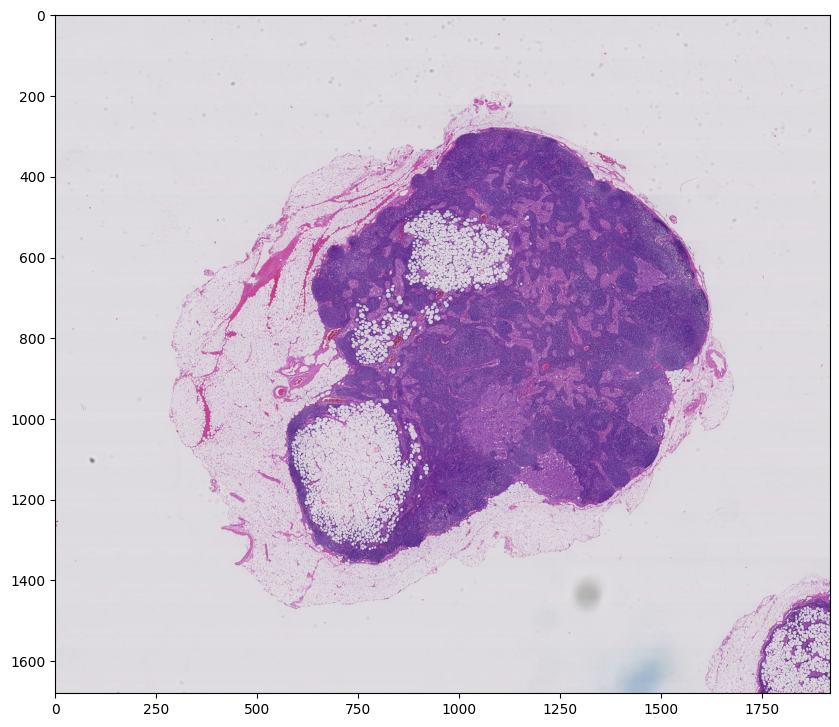

In [8]:
# Example: read the entire slide at level 5

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

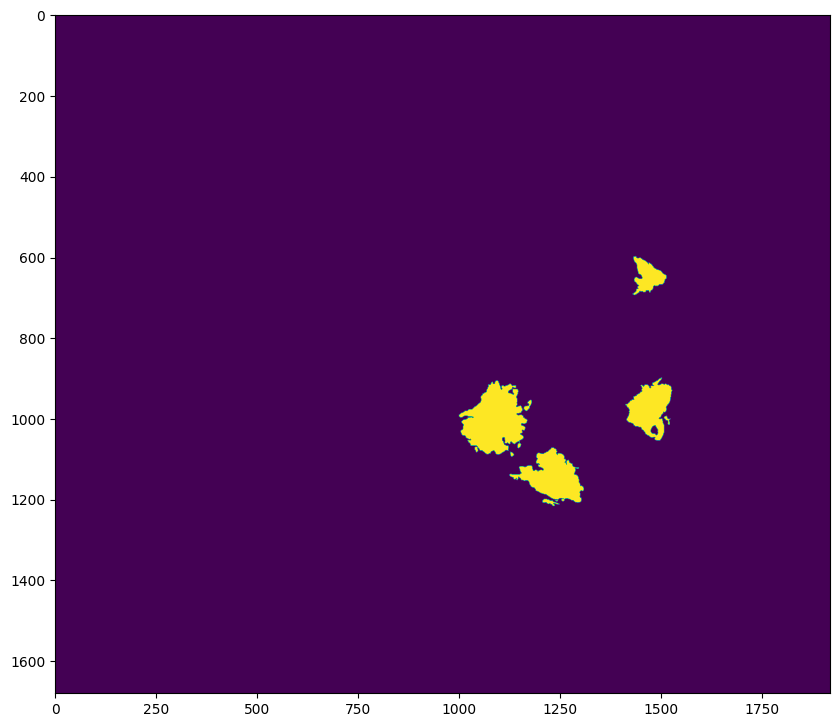

In [9]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

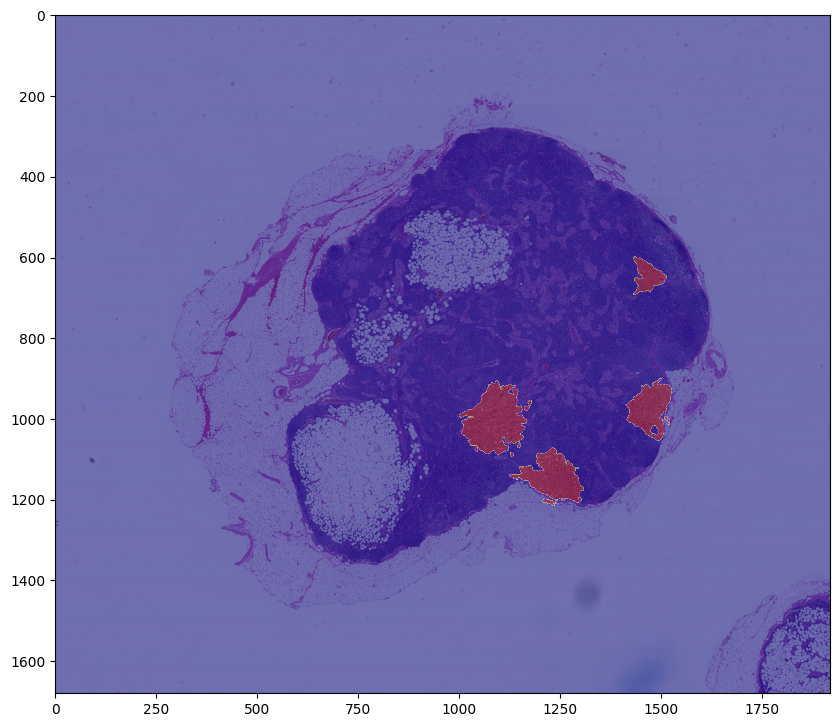

In [10]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

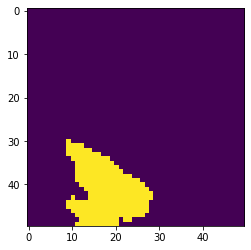

In [11]:
# Example: extract a region from the L7 downsampled image
# Multiply the x,y coordinates by the downsample factor.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


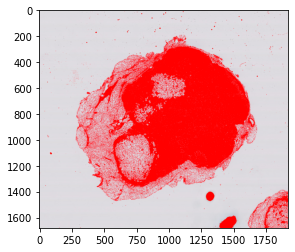

In [12]:
# Helper function to find and ignore non-tissue areas based on the gray pixels
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [13]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [14]:
# view a 299x299 patch at a time, check if it meets a threshold for non-gray
# pixels, and then store it somewhere. 299 is default input for inception V3.
# then grab the label from the mask

def load_from_slide(zoom, slide, tumor_mask, dir):
  downsample = int(slide.level_downsamples[zoom])
  window_width, window_height = 299,299
  seed = (1, 2)
  # df = pd.DataFrame(columns=["slide_name", "coordinates", "image", "label"])
  path = "/gdrive/MyDrive/ADL_project/%s/" % dir
  slide_height, slide_width = slide.level_dimensions[zoom] # order of width and height returned?

  for j in range(0, slide.level_dimensions[zoom][1] - window_height + 1, window_height):
    for i in range(0, slide.level_dimensions[zoom][0] - window_width + 1, window_width):
      label = 0.0
      window = read_slide(slide, 
                          x= i * downsample, 
                          y= j * downsample, 
                          level=zoom, 
                          width=window_width, 
                          height=window_height)
      
      tissue_pixels = find_tissue_pixels(window)
      percent_tissue = len(tissue_pixels) / float(window_width * window_height) * 100
      if (percent_tissue >= 30):
        # print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
        # print("i: %d, j: %d" % (i, j))
        
        
        # check the mask value for cancer label
        mask = read_slide(tumor_mask,
                          x=i* downsample, 
                          y=j* downsample, 
                          level=zoom, 
                          width=window_width, 
                          height=window_height)
        mask = mask[:,:,0]
        # if extrema values are same then only one color in the image
        # therefore there is no cancer. If they are different then
        # there is cancer. This seems to work but need to test on 
        # some other slides.
        mask_img = Image.fromarray(mask)
        stat = ImageStat.Stat(mask_img)
        # print("The mask image stats are:")
        # print(stat.extrema)
        if stat.extrema[0][0] != stat.extrema[0][1]: # multiple colors, so mask is telling me there's cancer
          window_img = Image.fromarray(window) #save array as image
          out_path = path + "pos" #to send to pos directory
          name = "slide_window_%d_%d_zoom%d.jpg" % (i, j, zoom) #name the slide based on coordinates
          out_file = os.path.join(out_path, name) #create file name
          if not os.path.exists(out_file): #only save if the file doesn't already exist
            window_img.save(out_file, "JPEG") #save file

          '''
          # send the files to separete zoom level folder 
          # right now this only works for 5 and 3 levels because those are what I 
          # have in my gdrive 
          two_path = "/gdrive/MyDrive/ADL_project/%s_%s/pos" % (zoom, dir)
          two_file = os.path.join(two_path, name)
          if not os.path.exists(two_file): #only save if the file doesn't already exist
            window_img.save(two_file, "JPEG") #save file
          '''
          
          '''
          # These are similar techniques for data augmentation used in the paper.
          # synthetic data actually makes my results worse and because the model finds too many false positives
          # create synthetic data with Pillow
          # rotate 90 degrees twice
          for factor in range(1, 4):
            rotated = window_img.rotate(90 * factor)
            rotated_name = "slide_window_%d_%d_zoom%d_rotate%d.jpg" % (i, j, zoom, 90*factor)
            rotated_file = os.path.join(out_path, rotated_name) # send to the same pos folder
            if not os.path.exists(rotated_file): #only save if the file doesn't already exist
              rotated.save(rotated_file, "JPEG") #save file
          
          # mirror the image and rotate 4 times
          mirrored = ImageOps.mirror(window_img)
          for factor in range(4):
            rotated = window_img.rotate(90 * factor)
            rotated_name = "slide_window_%d_%d_zoom%d_mrotate%d.jpg" % (i, j, zoom, 90*factor)
            rotated_file = os.path.join(out_path, rotated_name) # send to the same pos folder
            if not os.path.exists(rotated_file): #only save if the file doesn't already exist
              rotated.save(rotated_file, "JPEG") #save file
          '''
          
        else:
          window_img = Image.fromarray(window)
          out_path = path + "neg"
          name = "slide_window_%d_%d_zoom%d.jpg" % (i, j, zoom)
          out_file = os.path.join(out_path, name)
          if not os.path.exists(out_file):
            window_img.save(out_file, "JPEG")
          
          '''
          # send files to separate folder for parallel model that currently doesn't work
          two_path = "/gdrive/MyDrive/ADL_project/%s_%s/neg" % (zoom, dir)
          two_file = os.path.join(two_path, name)
          if not os.path.exists(two_file): #only save if the file doesn't already exist
            window_img.save(two_file, "JPEG") #save file
          '''


In [15]:
# load zoom levels for slide 91

zooms = [5, 3]
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [16]:
# repeat the above process with slide 012

slide_name = 'tumor_012.tif'
mask_name = 'tumor_012_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1551M  100 1551M    0     0   157M      0  0:00:09  0:00:09 --:--:--  160M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91.4M  100 91.4M    0     0   190M      0 --:--:-- --:--:-- --:--:--  189M


In [17]:
slide = open_slide(slide_name)
print ("Read WSI from %s with width: %d, height: %d" % (slide_name, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(mask_name)
print ("Read tumor mask from %s" % (mask_name))

print("Slide includes %d levels" % len(slide.level_dimensions))
print("Tumor mask includes %d levels" % len(tumor_mask.level_dimensions))
for i in range(min(len(tumor_mask.level_dimensions), len(slide.level_dimensions))):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]


# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_012.tif with width: 97792, height: 215552
Read tumor mask from tumor_012_mask.tif
Slide includes 10 levels
Tumor mask includes 9 levels
Level 0, dimensions: (97792, 215552) downsample factor 1
Level 1, dimensions: (48896, 107776) downsample factor 2
Level 2, dimensions: (24448, 53888) downsample factor 4
Level 3, dimensions: (12224, 26944) downsample factor 8
Level 4, dimensions: (6112, 13472) downsample factor 16
Level 5, dimensions: (3056, 6736) downsample factor 32
Level 6, dimensions: (1528, 3368) downsample factor 64
Level 7, dimensions: (764, 1684) downsample factor 128
Level 8, dimensions: (382, 842) downsample factor 256


In [18]:
zoom = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom, 
                         width=slide.level_dimensions[zoom][0], 
                         height=slide.level_dimensions[zoom][1])

In [19]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom, 
                        width=slide.level_dimensions[zoom][0], 
                        height=slide.level_dimensions[zoom][1])

mask_image = mask_image[:,:,0]

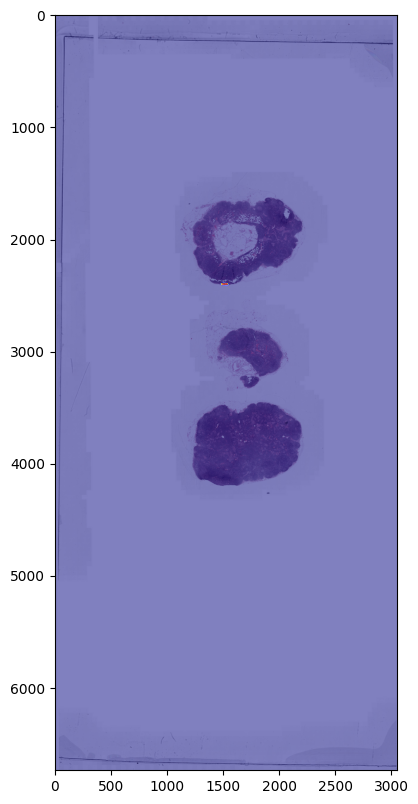

In [20]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [21]:
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [22]:
# repeat the above process with slide 075

slide_name = 'tumor_075.tif'
mask_name = 'tumor_075_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  893M  100  893M    0     0   134M      0  0:00:06  0:00:06 --:--:--  133M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.4M  100 31.4M    0     0  51.2M      0 --:--:-- --:--:-- --:--:-- 51.1M


In [23]:
slide = open_slide(slide_name)
tumor_mask = open_slide(mask_name)

In [24]:
zoom = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom, 
                         width=slide.level_dimensions[zoom][0], 
                         height=slide.level_dimensions[zoom][1])

In [25]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom, 
                        width=slide.level_dimensions[zoom][0], 
                        height=slide.level_dimensions[zoom][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

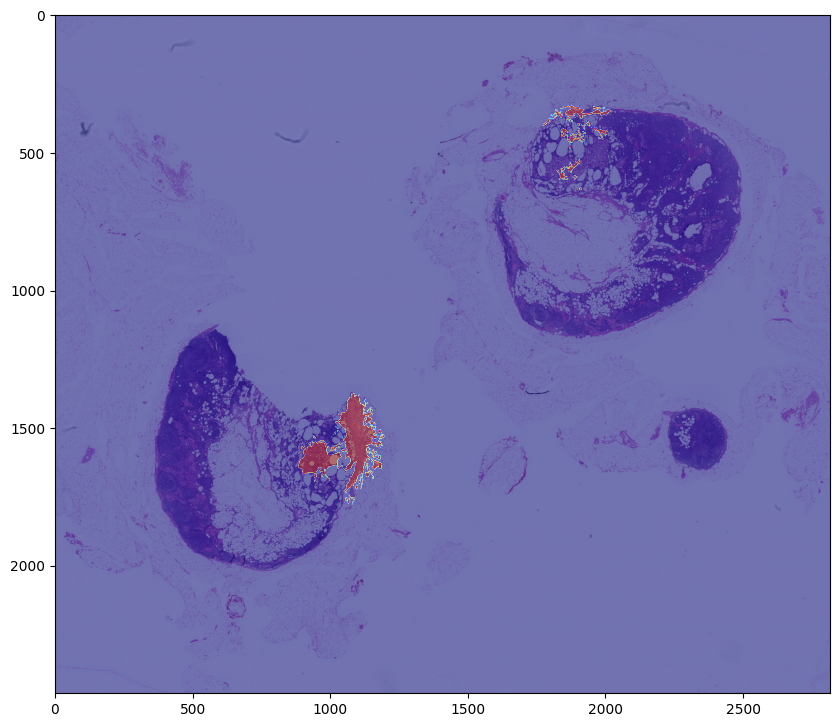

In [26]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [27]:
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [28]:
# More train data from slides 005
slide_name = 'tumor_005.tif'
mask_name = 'tumor_005_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1399M  100 1399M    0     0   176M      0  0:00:07  0:00:07 --:--:--  183M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93.1M  100 93.1M    0     0   123M      0 --:--:-- --:--:-- --:--:--  123M


In [29]:
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [30]:
# More train data from slides 023
slide_name = 'tumor_023.tif'
mask_name = 'tumor_023_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1609M  100 1609M    0     0   161M      0  0:00:09  0:00:09 --:--:--  177M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93.7M  100 93.7M    0     0  51.5M      0  0:00:01  0:00:01 --:--:-- 51.5M


In [31]:
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [32]:
# The final train slide from 110
slide_name = 'tumor_110.tif'
mask_name = 'tumor_110_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0   149M      0  0:00:09  0:00:09 --:--:--  152M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  76.0M      0 --:--:-- --:--:-- --:--:-- 76.0M


In [33]:
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="train")

In [34]:
# repeat the process to obtain validation set from 1 slide
slide_name = 'tumor_064.tif'
mask_name = 'tumor_064_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1569M  100 1569M    0     0   167M      0  0:00:09  0:00:09 --:--:--  187M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94.3M  100 94.3M    0     0  98.9M      0 --:--:-- --:--:-- --:--:-- 98.8M


In [35]:
slide = open_slide(slide_name)
tumor_mask = open_slide(mask_name)

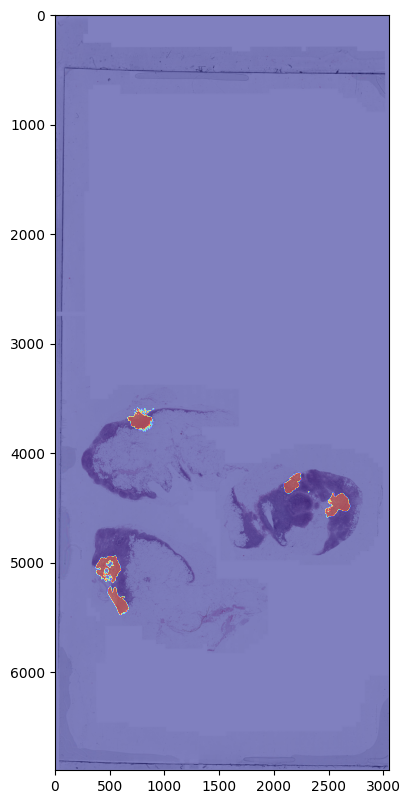

In [36]:
zoom = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom, 
                         width=slide.level_dimensions[zoom][0], 
                         height=slide.level_dimensions[zoom][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom, 
                        width=slide.level_dimensions[zoom][0], 
                        height=slide.level_dimensions[zoom][1])

mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [37]:
# load into val_df
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="val")

In [38]:
# repeat the process to obtain test set from slide 16
slide_name = 'tumor_016.tif'
mask_name = 'tumor_016_mask.tif'

download_slide(slide_name, mask_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0   118M      0  0:00:12  0:00:12 --:--:--  165M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 94.1M  100 94.1M    0     0   128M      0 --:--:-- --:--:-- --:--:--  128M


In [39]:
slide = open_slide(slide_name)
tumor_mask = open_slide(mask_name)

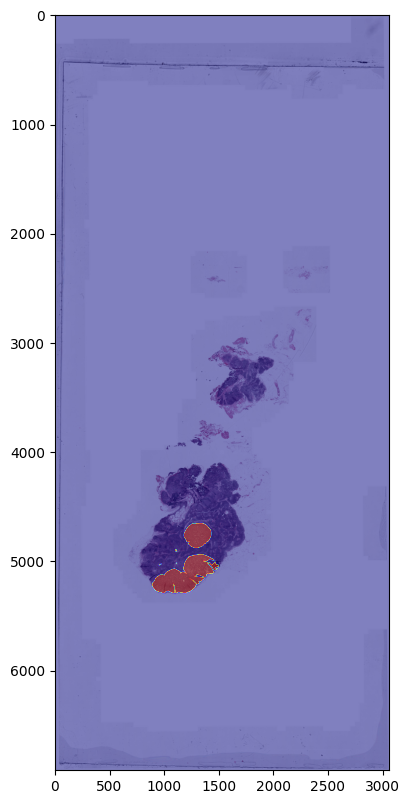

In [40]:
zoom = 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom, 
                         width=slide.level_dimensions[zoom][0], 
                         height=slide.level_dimensions[zoom][1])

mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom, 
                        width=slide.level_dimensions[zoom][0], 
                        height=slide.level_dimensions[zoom][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [41]:
# load into test dir
for zoom in zooms:
  load_from_slide(zoom=zoom, slide=slide, tumor_mask=tumor_mask, dir="test")

Code defining and running the model from this point onward

In [42]:
IMG_SIZE=299
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                  weights='imagenet', 
                                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False 

87910968/87910968 [==============================] - 0s 0us/step


In [43]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [44]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
train_dir = '/gdrive/MyDrive/ADL_project/train'
val_dir = '/gdrive/MyDrive/ADL_project/val'
test_dir = '/gdrive/MyDrive/ADL_project/test'

In [46]:
batch_size = 32
img_height = IMG_SIZE
img_width = IMG_SIZE

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1197 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


In [47]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels="inferred",
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 205 files belonging to 2 classes.


In [48]:
# list compression to get training labels from dataset object. Needed to modify weights
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

In [49]:
neg, pos = np.bincount(train_labels)
total = neg + pos

In [50]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.63
Weight for class 1: 2.36


In [51]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.25),
  tf.keras.layers.RandomContrast(0.75),
  tf.keras.layers.RandomBrightness(64.0/255.0)
])

In [52]:
AUTOTUNE = tf.data.AUTOTUNE
# speed pipeline
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
model.fit(train_ds, validation_data=val_ds, epochs=8)

Epoch 1/8
38/38 [==============================] - 20s 182ms/step - loss: 2.0661 - accuracy: 0.7669 - val_loss: 2.0704 - val_accuracy: 0.7278
Epoch 2/8
38/38 [==============================] - 1s 35ms/step - loss: 1.1497 - accuracy: 0.7962 - val_loss: 1.3604 - val_accuracy: 0.7611
Epoch 3/8
38/38 [==============================] - 1s 35ms/step - loss: 0.7980 - accuracy: 0.8020 - val_loss: 0.8853 - val_accuracy: 0.7278
Epoch 4/8
38/38 [==============================] - 1s 35ms/step - loss: 0.7374 - accuracy: 0.8229 - val_loss: 0.8997 - val_accuracy: 0.6944
Epoch 5/8
38/38 [==============================] - 1s 35ms/step - loss: 0.7211 - accuracy: 0.8287 - val_loss: 0.9393 - val_accuracy: 0.6667
Epoch 6/8
38/38 [==============================] - 1s 35ms/step - loss: 0.6710 - accuracy: 0.8396 - val_loss: 0.9562 - val_accuracy: 0.6667
Epoch 7/8
38/38 [==============================] - 1s 35ms/step - loss: 0.6266 - accuracy: 0.8413 - val_loss: 1.0002 - val_accuracy: 0.6444
Epoch 8/8
38/38 [=

In [54]:
test_loss, test_acc = model.evaluate(test_ds)

7/7 [==============================] - 4s 535ms/step - loss: 0.9412 - accuracy: 0.7512


In [55]:
slide_name = 'tumor_016.tif'
mask_name = 'tumor_016_mask.tif'

slide = open_slide(slide_name)
tumor_mask = open_slide(mask_name)

In [56]:
def gen_heatmap(zoom, slide, my_model):
  window_width, window_height = 299,299
  slide_width, slide_height  = slide.level_dimensions[zoom]
  downsample = int(slide.level_downsamples[zoom])
  mask = np.zeros((slide_height, slide_width, 3)) # fill entire array with purple
  
  for j in range(0, slide_height - window_height + 1, window_height):
    for i in range(0, slide_width - window_width + 1, window_width):
      
      window = read_slide(slide, 
                          x= i * downsample, 
                          y= j * downsample, 
                          level=zoom, 
                          width=window_width, 
                          height=window_height)
      
      #ignore gray patches
      tissue_pixels = find_tissue_pixels(window)
      percent_tissue = len(tissue_pixels) / float(window_width * window_height) * 100
      if (percent_tissue >= 30):
        #get the prediction
        to_predict = tf.expand_dims(window, axis=0) #wrap window in batch
        res = my_model.predict(to_predict, verbose=0)
        prediction = np.argmax(res)
        # print("prediction,", prediction)
        if (prediction == 1):
          for y in range(j, min(j+window_height, slide_height)-1, 1): # fill in mask from j to j+window_height
            # fill in mask from i to i+window_width
            for x in range(i, min(i+window_width, slide_height)-1, 1):
              mask[y][x][0] = 1
  return mask

In [57]:
MAP_ZOOM = 3
heatmap = gen_heatmap(MAP_ZOOM, slide, model)

In [58]:
def map_sidebyside(heatmap):
  MAP_ZOOM
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=MAP_ZOOM, 
                          width=slide.level_dimensions[MAP_ZOOM][0], 
                          height=slide.level_dimensions[MAP_ZOOM][1])

  print("Predicted heatmap vs. actual mask")
  plt.subplot(1, 2, 1)
  plt.imshow(slide_image)
  plt.imshow(heatmap, cmap='jet', alpha=0.5)

  zoom=5 #zoom out to more easily render the heatmap
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=zoom, 
                          width=slide.level_dimensions[zoom][0], 
                          height=slide.level_dimensions[zoom][1])
  mask_image = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=zoom, 
                          width=slide.level_dimensions[zoom][0], 
                          height=slide.level_dimensions[zoom][1])
  mask_image = mask_image[:,:,0]
  plt.subplot(1, 2, 2)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap='jet', alpha=0.5)

Predicted heatmap vs. actual mask


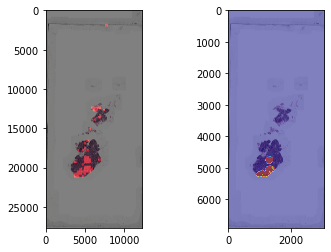

In [59]:
map_sidebyside(heatmap)

In [60]:
from sklearn.metrics import classification_report, roc_auc_score

test_label = np.concatenate([y for x, y in test_ds], axis=0)
prob = model.predict(test_ds)
test_pred = np.argmax(prob, axis=-1)

print(classification_report(test_label, test_pred, target_names=['negative', 'positive']))

7/7 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83       156
    positive       0.48      0.53      0.50        49

    accuracy                           0.75       205
   macro avg       0.66      0.68      0.67       205
weighted avg       0.76      0.75      0.76       205



In [61]:
print("AUROC score on vanilla model is: ", roc_auc_score(test_label, prob[:, 1]))

AUROC score on vanilla model is:  0.7417582417582417


In [62]:
aug_model = tf.keras.Sequential([
  data_augmentation, # I couldn't make data augmentation on only positive labels work so just using an augmentation layer
  base_model,
  global_average_layer,
  prediction_layer
])

In [63]:
aug_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
model.fit(train_ds, validation_data=val_ds, epochs=8)

Epoch 1/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4660 - accuracy: 0.8563 - val_loss: 1.0858 - val_accuracy: 0.6389
Epoch 2/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4808 - accuracy: 0.8546 - val_loss: 1.1759 - val_accuracy: 0.6111
Epoch 3/8
38/38 [==============================] - 1s 35ms/step - loss: 0.6689 - accuracy: 0.8363 - val_loss: 1.9622 - val_accuracy: 0.7278
Epoch 4/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4939 - accuracy: 0.8563 - val_loss: 0.9774 - val_accuracy: 0.7333
Epoch 5/8
38/38 [==============================] - 1s 35ms/step - loss: 0.3884 - accuracy: 0.8688 - val_loss: 1.0233 - val_accuracy: 0.7111
Epoch 6/8
38/38 [==============================] - 1s 35ms/step - loss: 0.3747 - accuracy: 0.8622 - val_loss: 1.3842 - val_accuracy: 0.7222
Epoch 7/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4188 - accuracy: 0.8672 - val_loss: 1.1808 - val_accuracy: 0.7056
Epoch 8/8
38/38 [===

In [65]:
# show heatmap of augmented model
aug_heatmap = gen_heatmap(MAP_ZOOM, slide, model)


Predicted heatmap vs. actual mask


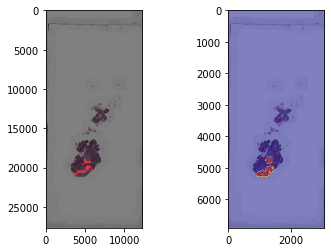

In [66]:
map_sidebyside(aug_heatmap)

In [67]:
prob = aug_model.predict(test_ds)
test_pred = np.argmax(prob, axis=-1)

print(classification_report(test_label, test_pred, target_names=['negative', 'positive']))

7/7 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

    negative       0.80      0.98      0.88       156
    positive       0.77      0.20      0.32        49

    accuracy                           0.80       205
   macro avg       0.78      0.59      0.60       205
weighted avg       0.79      0.80      0.75       205



In [68]:
print("AUROC score with augmentation is: ", roc_auc_score(test_label, prob[:, 1]))

AUROC score with augmentation is:  0.7488226059654631


Do the same thing, but now with no augmentation and passed class weights to deal with class imbalance

In [69]:
weighted_model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [70]:
weighted_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
weighted_model.fit(train_ds, validation_data=val_ds, epochs=8, class_weight=class_weight)

Epoch 1/8
38/38 [==============================] - 6s 68ms/step - loss: 1.5549 - accuracy: 0.7293 - val_loss: 1.7255 - val_accuracy: 0.5778
Epoch 2/8
38/38 [==============================] - 1s 35ms/step - loss: 0.5407 - accuracy: 0.8454 - val_loss: 0.9210 - val_accuracy: 0.7333
Epoch 3/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4477 - accuracy: 0.8496 - val_loss: 0.9823 - val_accuracy: 0.6889
Epoch 4/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4726 - accuracy: 0.8329 - val_loss: 1.1664 - val_accuracy: 0.6389
Epoch 5/8
38/38 [==============================] - 1s 35ms/step - loss: 0.5083 - accuracy: 0.8379 - val_loss: 1.0518 - val_accuracy: 0.6722
Epoch 6/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4985 - accuracy: 0.8454 - val_loss: 0.9576 - val_accuracy: 0.7611
Epoch 7/8
38/38 [==============================] - 1s 35ms/step - loss: 0.4403 - accuracy: 0.8454 - val_loss: 0.9997 - val_accuracy: 0.7556
Epoch 8/8
38/38 [===

In [72]:
weighted_heatmap = gen_heatmap(MAP_ZOOM, slide, weighted_model)

Predicted heatmap vs. actual mask


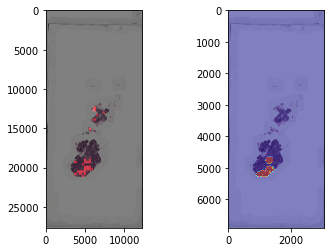

In [73]:
map_sidebyside(weighted_heatmap)

In [74]:
prob = weighted_model.predict(test_ds)
test_pred = np.argmax(prob, axis=-1)

print(classification_report(test_label, test_pred, target_names=['negative', 'positive']))
print("AUROC score with class weights is: ", roc_auc_score(test_label, prob[:, 1]))

7/7 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86       156
    positive       0.55      0.37      0.44        49

    accuracy                           0.78       205
   macro avg       0.68      0.64      0.65       205
weighted avg       0.75      0.78      0.76       205

AUROC score with class weights is:  0.7314233385661957


In [75]:
from tensorflow.keras.layers import Dropout
from keras import models, layers
input_shape = (299, 299, 3)

CNN = models.Sequential()
CNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D())
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(layers.MaxPooling2D())
CNN.add(layers.Flatten())
CNN.add(layers.Dense(128, activation='relu'))
CNN.add(layers.Dense(2, activation='softmax'))

In [76]:
CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [77]:
CNN.fit(train_ds, validation_data=val_ds, epochs=8)

Epoch 1/8
38/38 [==============================] - 5s 68ms/step - loss: 1832.2656 - accuracy: 0.6583 - val_loss: 0.6804 - val_accuracy: 0.7167
Epoch 2/8
38/38 [==============================] - 2s 53ms/step - loss: 0.4917 - accuracy: 0.7853 - val_loss: 0.6912 - val_accuracy: 0.7167
Epoch 3/8
38/38 [==============================] - 2s 53ms/step - loss: 0.3975 - accuracy: 0.8070 - val_loss: 0.6921 - val_accuracy: 0.7167
Epoch 4/8
38/38 [==============================] - 2s 54ms/step - loss: 0.3717 - accuracy: 0.8429 - val_loss: 0.6921 - val_accuracy: 0.7167
Epoch 5/8
38/38 [==============================] - 2s 54ms/step - loss: 0.3674 - accuracy: 0.8530 - val_loss: 0.6914 - val_accuracy: 0.7167
Epoch 6/8
38/38 [==============================] - 2s 54ms/step - loss: 0.3445 - accuracy: 0.8605 - val_loss: 0.6908 - val_accuracy: 0.7167
Epoch 7/8
38/38 [==============================] - 2s 54ms/step - loss: 0.3327 - accuracy: 0.8697 - val_loss: 0.6902 - val_accuracy: 0.7167
Epoch 8/8
38/38 [

In [78]:
cnn_heatmap = gen_heatmap(MAP_ZOOM, slide, CNN)

Predicted heatmap vs. actual mask


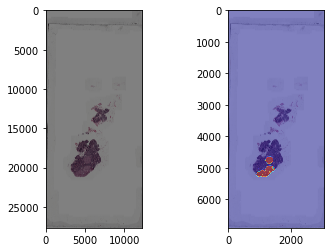

In [79]:
map_sidebyside(cnn_heatmap)

In [80]:
prob = CNN.predict(test_ds)
test_pred = np.argmax(prob, axis=-1)

print(classification_report(test_label, test_pred, target_names=['negative', 'positive']))
print("AUROC score with CNN is: ", roc_auc_score(test_label, prob[:, 1]))

7/7 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

    negative       0.76      1.00      0.86       156
    positive       0.00      0.00      0.00        49

    accuracy                           0.76       205
   macro avg       0.38      0.50      0.43       205
weighted avg       0.58      0.76      0.66       205

AUROC score with CNN is:  0.7558869701726845


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This is my unsuccessful attempt at a parallel two tower structure for multiple zoom levels

In [81]:
'''
# Load parallel zoom datasets for train, val, and test
out_train_dir = '/gdrive/MyDrive/ADL_project/5_train'
out_val_dir = '/gdrive/MyDrive/ADL_project/5_val'
out_test_dir = '/gdrive/MyDrive/ADL_project/5_test'

in_train_dir = '/gdrive/MyDrive/ADL_project/3_train'
in_val_dir = '/gdrive/MyDrive/ADL_project/3_val'
in_test_dir = '/gdrive/MyDrive/ADL_project/3_test'

batch_size = 32
img_height = IMG_SIZE
img_width = IMG_SIZE

# load the zoomed out datasets
out_train_ds = tf.keras.utils.image_dataset_from_directory(
  out_train_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

out_val_ds = tf.keras.utils.image_dataset_from_directory(
  out_val_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

out_test_ds = tf.keras.utils.image_dataset_from_directory(
  out_test_dir,
  labels="inferred",
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# load the zoomed in datasets
in_train_ds = tf.keras.utils.image_dataset_from_directory(
  in_train_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

in_val_ds = tf.keras.utils.image_dataset_from_directory(
  in_val_dir,
  labels="inferred",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

in_test_ds = tf.keras.utils.image_dataset_from_directory(
  in_test_dir,
  labels="inferred",
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)
'''

'\n# Load parallel zoom datasets for train, val, and test\nout_train_dir = \'/gdrive/MyDrive/ADL_project/5_train\'\nout_val_dir = \'/gdrive/MyDrive/ADL_project/5_val\'\nout_test_dir = \'/gdrive/MyDrive/ADL_project/5_test\'\n\nin_train_dir = \'/gdrive/MyDrive/ADL_project/3_train\'\nin_val_dir = \'/gdrive/MyDrive/ADL_project/3_val\'\nin_test_dir = \'/gdrive/MyDrive/ADL_project/3_test\'\n\nbatch_size = 32\nimg_height = IMG_SIZE\nimg_width = IMG_SIZE\n\n# load the zoomed out datasets\nout_train_ds = tf.keras.utils.image_dataset_from_directory(\n  out_train_dir,\n  labels="inferred",\n  seed=123,\n  shuffle=True,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\n\nout_val_ds = tf.keras.utils.image_dataset_from_directory(\n  out_val_dir,\n  labels="inferred",\n  seed=123,\n  shuffle=True,\n  image_size=(img_height, img_width),\n  batch_size=batch_size)\n\nout_test_ds = tf.keras.utils.image_dataset_from_directory(\n  out_test_dir,\n  labels="inferred",\n  seed=123,\n  shuffle=

In [82]:
'''
out_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
out_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
out_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

in_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
in_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
in_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
'''

'\nout_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)\nout_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\nout_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)\n\nin_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)\nin_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)\nin_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)\n'

In [83]:
'''
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, Conv2D, Embedding
from tensorflow.keras.models import Sequential, Model

# create one tower for zoomed out images
out_input = Input(shape=(299, 299, 3)) # what's the input size?
out_model = Sequential()
out_model.add(model)
# get the vector of the zoomed out images model
encoded_out = out_model(out_input)

# do the same for zoomed in
in_input = Input(shape=(299, 299, 3))
in_model = Sequential()
in_model.add(model)
encoded_in = in_model(in_input)

merged = tf.keras.layers.concatenate([encoded_out, encoded_in])

dense = Dense(5, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)
two_towers = Model(inputs=[out_input, in_input], outputs=output)
'''

"\nfrom tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, Conv2D, Embedding\nfrom tensorflow.keras.models import Sequential, Model\n\n# create one tower for zoomed out images\nout_input = Input(shape=(299, 299, 3)) # what's the input size?\nout_model = Sequential()\nout_model.add(model)\n# get the vector of the zoomed out images model\nencoded_out = out_model(out_input)\n\n# do the same for zoomed in\nin_input = Input(shape=(299, 299, 3))\nin_model = Sequential()\nin_model.add(model)\nencoded_in = in_model(in_input)\n\nmerged = tf.keras.layers.concatenate([encoded_out, encoded_in])\n\ndense = Dense(5, activation='relu')(merged)\noutput = Dense(1, activation='sigmoid')(dense)\ntwo_towers = Model(inputs=[out_input, in_input], outputs=output)\n"

In [84]:
'''
two_towers.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
'''

"\ntwo_towers.compile(optimizer='adam', \n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n"

In [85]:
'''
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')
'''

"\n# Utilities to help us record metrics.\n# You should not need to modify this code\ntrain_loss = tf.keras.metrics.Mean(name='train_loss')\ntrain_accuracy = tf.keras.metrics.Mean(name='train_accuracy')\n\nval_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')\nval_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')\n"

In [86]:
'''
# used for two towers, model doesn't work
def evaluate(max_steps=None):
  steps = 0
  for out_img, out_lab, in_img, in_lab in out_val_ds, in_val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[out_img, in_img])
    steps += 1 
    # Record metrics after each batch
    val_loss(in_lab, predictions)
    val_accuracy(in_lab, predictions)
'''

"\n# used for two towers, model doesn't work\ndef evaluate(max_steps=None):\n  steps = 0\n  for out_img, out_lab, in_img, in_lab in out_val_ds, in_val_ds:\n    if max_steps != None and steps == max_steps:\n      break\n    predictions = model.predict(x=[out_img, in_img])\n    steps += 1 \n    # Record metrics after each batch\n    val_loss(in_lab, predictions)\n    val_accuracy(in_lab, predictions)\n"

In [87]:
'''
# possible to use glob to construct and parse a list of paths for each zoom level
# to create each train path to pass into from_tensor_slices
path_ds = tf.data.Dataset.from_tensor_slices((train_paths_L1, train_paths_L2))
image_ds = path_ds.map(lambda L1, L2 : (load_and_preprocess_image(L1), load_and_preprocess_image(L2)), num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
'''

'\n# possible to use glob to construct and parse a list of paths for each zoom level\n# to create each train path to pass into from_tensor_slices\npath_ds = tf.data.Dataset.from_tensor_slices((train_paths_L1, train_paths_L2))\nimage_ds = path_ds.map(lambda L1, L2 : (load_and_preprocess_image(L1), load_and_preprocess_image(L2)), num_parallel_calls=AUTOTUNE)\nlabel_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))\n'

In [88]:
'''
# this is my failed attempt at making the parallel tower architecture work
import time
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for out_img, out_lab, in_img, in_lab in out_train_ds, in_train_ds:
    result = two_towers.train_on_batch(x=[out_img, in_img], y=in_lab)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))
  
  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()
'''

"\n# this is my failed attempt at making the parallel tower architecture work\nimport time\ntrain_loss_history, train_acc_history = [], []\nval_loss_history, val_acc_history = [], []\n\nepochs = 10 # Your code here\n\n# Training loop\nfor epoch in range(epochs):\n\n  start = time.time()\n\n  # Train for one epoch\n  for out_img, out_lab, in_img, in_lab in out_train_ds, in_train_ds:\n    result = two_towers.train_on_batch(x=[out_img, in_img], y=in_lab)\n\n    # Record metrics after each batch\n    train_loss(result[0])\n    train_accuracy(result[1])\n\n  # Evaluate for a few steps\n  evaluate(max_steps=100)\n\n  # Print progress\n  # You should not need to modify this.\n  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'\n  print(template.format(epoch,\n                        train_loss.result(),\n                        train_accuracy.result() * 100,\n                        val_loss.result(),\n                        val_ac

In [89]:
'''
two_towers.fit([out_train_ds, in_train_ds], 
               validation_data=[out_val_ds, in_val_ds], 
               epochs=10)
'''

'\ntwo_towers.fit([out_train_ds, in_train_ds], \n               validation_data=[out_val_ds, in_val_ds], \n               epochs=10)\n'

In [90]:
'''
test_label = np.concatenate([y for x, y in in_test_ds[1]], axis=0)
prob = two_towers.predict(test_ds)
test_pred = np.argmax(prob, axis=-1)

print(classification_report(test_label, test_pred, target_names=['negative', 'positive']))
print("AUROC score on the parallel tower model is: ", roc_auc_score(test_label, prob[:, 1]))
'''

'\ntest_label = np.concatenate([y for x, y in in_test_ds[1]], axis=0)\nprob = two_towers.predict(test_ds)\ntest_pred = np.argmax(prob, axis=-1)\n\nprint(classification_report(test_label, test_pred, target_names=[\'negative\', \'positive\']))\nprint("AUROC score on the parallel tower model is: ", roc_auc_score(test_label, prob[:, 1]))\n'